In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import murmurhash3_32

In [7]:
# --- 1. SETUP PARAMETERS AND RANDOM VALUES ---

P = 1048573
NUM_KEYS = 5000
INPUT_BITS = 31
OUTPUT_BITS = 10
OUTPUT_MOD = 2**OUTPUT_BITS  # This is 1024

# Generate and store the random coefficients for polynomial hashes
# Using fixed seeds for reproducibility of the random coefficients
np.random.seed(42)
a = np.random.randint(1, P)
b = np.random.randint(1, P)
c = np.random.randint(1, P)
d = np.random.randint(1, P)

print("--- Generated Coefficients ---")
print(f"P = {P}")
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")
print(f"d = {d}")
print("-" * 30)

# Generate 5000 random 31-bit positive integer keys
keys = np.random.randint(1, 2**INPUT_BITS, size=NUM_KEYS, dtype=np.int64)


--- Generated Coefficients ---
P = 1048573
a = 929095
b = 899292
c = 817160
d = 473254
------------------------------


In [8]:
# --- 2. DEFINE THE HASH FUNCTIONS ---

def h_2_universal(x):
    """((ax + b) mod P) mod 1024"""
    return ((a * x + b) % P) % OUTPUT_MOD

def h_3_universal(x):
    """((ax^2 + bx + c) mod P) mod 1024"""
    res = (a * x * x + b * x + c) % P
    return res % OUTPUT_MOD

def h_4_universal(x):
    """((ax^3 + bx^2 + cx + d) mod P) mod 1024"""
    res = (a * x * x * x + b * x * x + c * x + d) % P
    return res % OUTPUT_MOD

def h_murmur(x):
    """murmurhash3_32 with a fixed seed, constrained to 10 bits"""
    # Cast to int() to avoid TypeError with numpy.int64
    return murmurhash3_32(int(x), seed=0, positive=True) % OUTPUT_MOD

In [9]:
# --- 3. AVALANCHE ANALYSIS FUNCTION ---

def run_avalanche_analysis(hash_function, func_name):
    """
    Performs the avalanche analysis for a given hash function
    and returns a probability matrix.
    """
    print(f"Running analysis for {func_name}...")
    flip_counts = np.zeros((INPUT_BITS, OUTPUT_BITS), dtype=int)

    for x in keys:
        h_original = hash_function(x)
        for j in range(INPUT_BITS):
            x_flipped = x ^ (1 << j)
            h_flipped = hash_function(x_flipped)
            changed_bits = h_original ^ h_flipped
            for i in range(OUTPUT_BITS):
                if (changed_bits >> i) & 1:
                    flip_counts[j, i] += 1

    return flip_counts / NUM_KEYS


Running analysis for 2-Universal Hash...


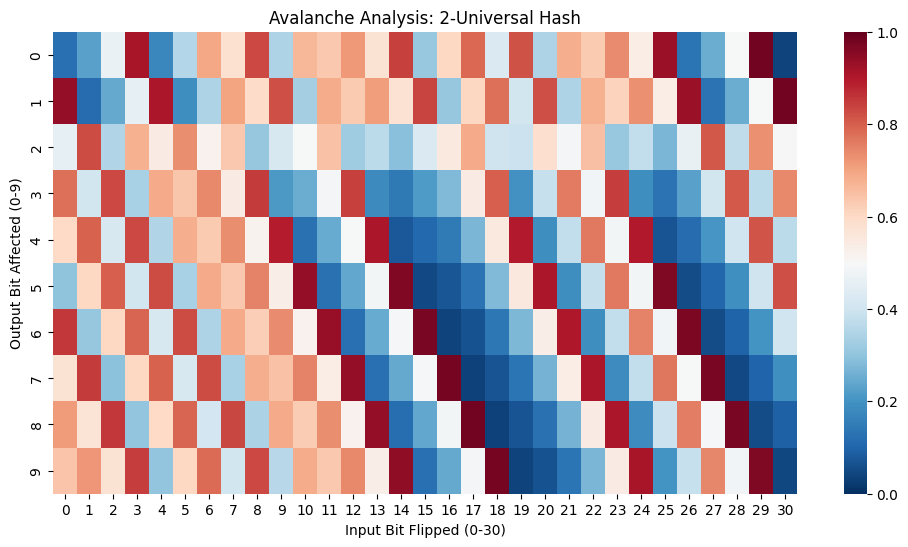

Running analysis for 3-Universal Hash...


/tmp/ipython-input-2212877750.py:9: RuntimeWarning: overflow encountered in scalar multiply
  res = (a * x * x + b * x + c) % P
/tmp/ipython-input-2212877750.py:9: RuntimeWarning: overflow encountered in scalar add
  res = (a * x * x + b * x + c) % P


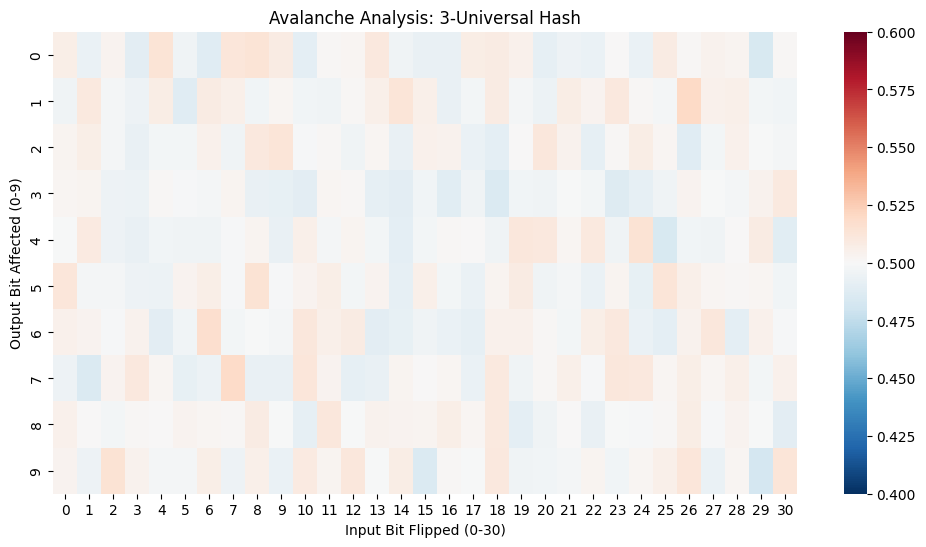

Running analysis for 4-Universal Hash...


/tmp/ipython-input-2212877750.py:14: RuntimeWarning: overflow encountered in scalar multiply
  res = (a * x * x * x + b * x * x + c * x + d) % P
/tmp/ipython-input-2212877750.py:14: RuntimeWarning: overflow encountered in scalar add
  res = (a * x * x * x + b * x * x + c * x + d) % P


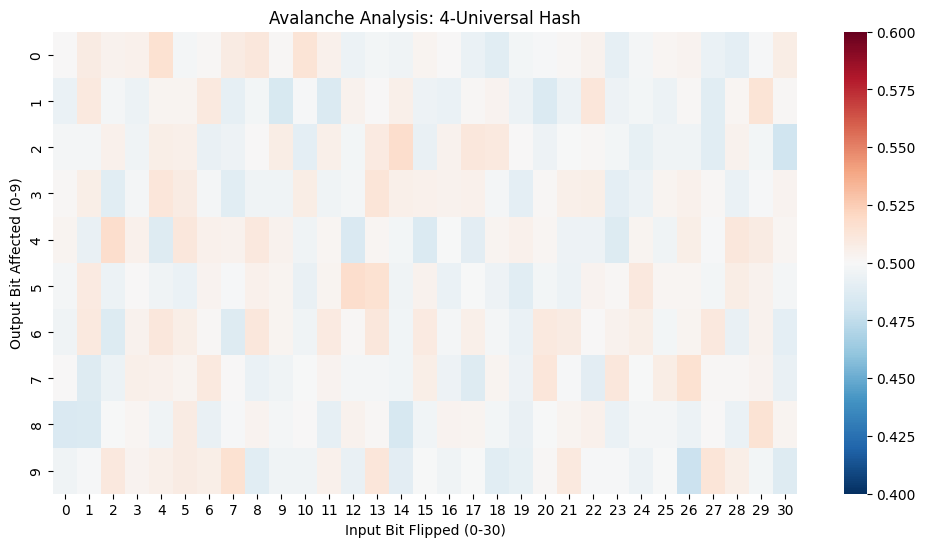

Running analysis for MurmurHash3...


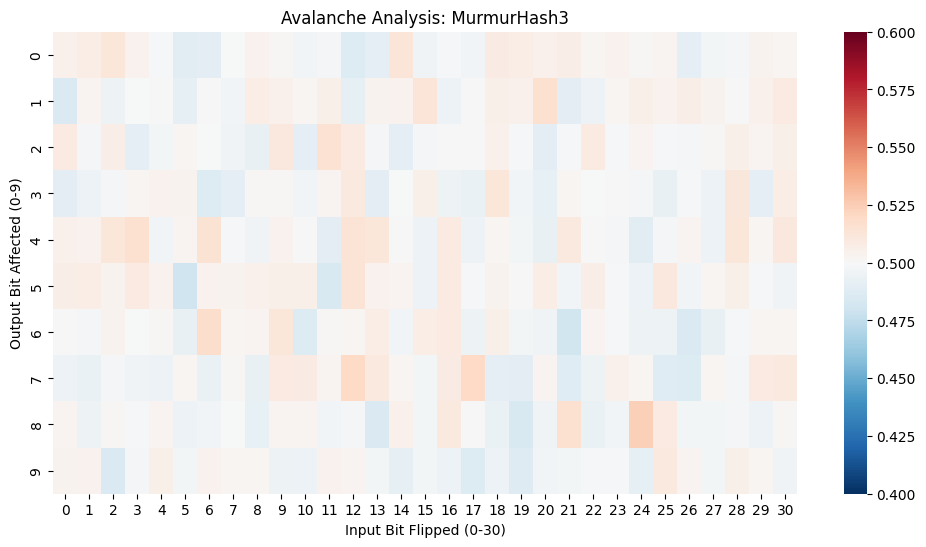

In [10]:
# --- 4. PLOTTING FUNCTION (darker diverging colormap) ---

def plot_heatmap(probability_matrix, title, vmin=0.0, vmax=1.0):
    """
    Generates and displays a heatmap for the given probability matrix.
    Uses a darker diverging colormap for better visibility.
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        probability_matrix.T,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        center=0.5
    )
    plt.xlabel("Input Bit Flipped (0-30)")
    plt.ylabel("Output Bit Affected (0-9)")
    plt.title(f"Avalanche Analysis: {title}")
    plt.show()


# --- 5. RUN EXPERIMENT AND VISUALIZE RESULTS ---

hash_functions = {
    "2-Universal Hash": h_2_universal,
    "3-Universal Hash": h_3_universal,
    "4-Universal Hash": h_4_universal,
    "MurmurHash3": h_murmur
}

for idx, (name, func) in enumerate(hash_functions.items()):
    prob_matrix = run_avalanche_analysis(func, name)
    if idx == 0:
        plot_heatmap(prob_matrix, name, vmin=0.0, vmax=1.0)
    else:
        plot_heatmap(prob_matrix, name, vmin=0.4, vmax=0.6)


**Results and Plots**

The heatmaps visualize the probability matrix. The x-axis represents the input bit being flipped (0-30),
and the y-axis represents the output bit being affected (0-9). The ideal plot would be uniformly dark,
showing all probabilities are near 0.5.

Polynomial Hash Functions (2, 3, and 4-Universal)
The plots for the first three hash functions will look very similar. They expose highly structured patterns,
indicating poor performance.

Appearance: These plots are dominated by bright blue (probability near 0) and bright red (probability near 1) stripes.
There are clear diagonal relationships, showing that low-order input bits only affect low-order output bits.

Interpretation: This demonstrates a very poor avalanche effect. The output is predictable. The two-stage modulo
operation (mod P then mod 1024) fails to adequately mix the bits, so changes in the input don't propagate across
the entire output.

MurmurHash3
The plot for MurmurHash3 looks completely different and demonstrates the desired behavior.

Appearance: This heatmap looks like random noise. Most of the grid is a dark, neutral color, indicating that the
    probabilities are clustered tightly around the ideal value of 0.5. There are no discernible patterns or stripes.

Interpretation: This signifies an excellent avalanche effect. Flipping any input bit creates a chaotic,
    unpredictable change across all output bits. This is exactly what a good general-purpose hash function should do.

**Conclusion**
   
The experiment clearly shows that MurmurHash3 has a vastly superior avalanche effect compared to the simple polynomial
    hash functions. While the polynomial hashes have theoretical guarantees of universality, they fail this practical
    test of bit-mixing. Their predictable structure makes them unsuitable for applications requiring good distribution,
    like hash tables. MurmurHash3, which was specifically designed with bitwise shifts, rotations, and multiplications
    to create chaos, performs almost ideally. It effectively scrambles the input bits to ensure that small input changes
    result in large, unpredictable output changes, fulfilling the goal of the avalanche effect.